In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
file_dir = '/Users/fanxinwei/Desktop/code/git_repo/dsmp-2024-group20/'
stock_file = file_dir + 'feature_extract/time_window_outputs/2025-01-02LOBs_5_seconds.csv'
df = pd.read_csv(stock_file)
df.head(10)

,time_window,avg_price,max_bid
0,0.0,317.886364,264
1,5.0,271.472973,267
2,10.0,268.141026,267
3,15.0,266.000000,266
4,20.0,266.318182,268
5,25.0,268.521739,270
6,30.0,265.709091,266
7,35.0,262.273333,263
8,40.0,258.852941,259
9,45.0,258.761194,258


In [4]:
df.shape

(6120, 3)

In [5]:
# trade time start from 08:00:00
start_date = pd.to_datetime('2025-01-02 08:00:00')
df['actual_datetime'] = start_date + pd.to_timedelta(df['time_window'], unit='s')
df.set_index('actual_datetime', inplace=True)
price = df['avg_price']
price.head(10)

actual_datetime
2025-01-02 08:00:00    317.886364
2025-01-02 08:00:05    271.472973
2025-01-02 08:00:10    268.141026
2025-01-02 08:00:15    266.000000
2025-01-02 08:00:20    266.318182
2025-01-02 08:00:25    268.521739
2025-01-02 08:00:30    265.709091
2025-01-02 08:00:35    262.273333
2025-01-02 08:00:40    258.852941
2025-01-02 08:00:45    258.761194
Name: avg_price, dtype: float64

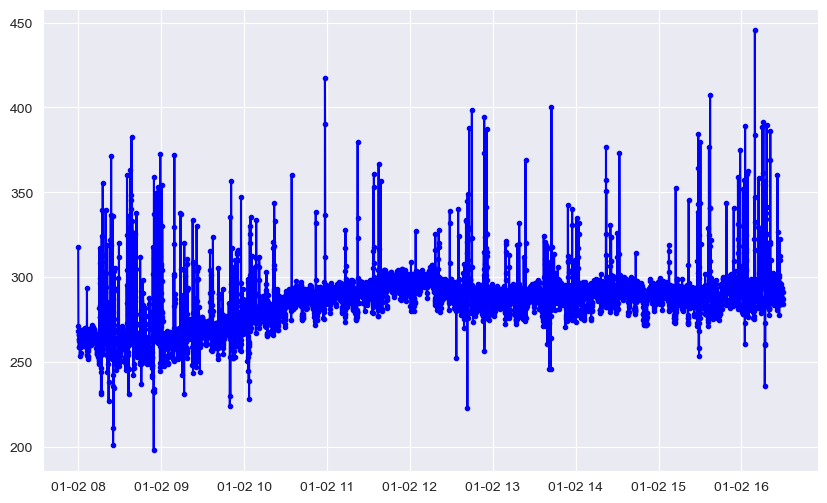

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(price, marker='.', linestyle='-', color='b')
plt.grid(True)

In [7]:
train_data = price[:-100]
test_data = price[-100:]
train_data_diff = train_data.diff(1)
train_data_diff = train_data_diff.dropna()


In [8]:
from statsmodels.tsa.stattools import adfuller
# ADF test (ADF(Augmented Dickey-Fuller) 强迪基-福勒检验)
def ADFtest(timeseries):
    # 执行Augmented Dickey-Fuller测试
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
ADFtest(train_data_diff)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -21.133974
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    5984.000000
Critical Value (1%)              -3.431443
Critical Value (5%)              -2.862023
Critical Value (10%)             -2.567027
dtype: float64


In [9]:
# cross validation
## using auto_arima to find the best ARIMA model
import pmdarima as pm
## 自动寻找最佳ARIMA模型

### remember to check y is base on with training data: train_avg ? or train_wavg?
auto_model = pm.auto_arima( train_data, start_p=0, start_q=0,
                            test='adf',
                            max_p=10, max_q=10,
                            seasonal=False,   ## if seasonal=True, need to add "start_P = " and "D="
                            # although "False" is been choosen, must set the "m="( but "m=" does't work)
                            suppress_warnings= 'True',
                            information_criterion= 'aic', ## using aic to choose the best model
                            error_action='ignore',
                            stepwise= False,    ## “True”(default) may cannot find the best way, but "False" will waste more time.
                            trace= True   ## print the detail of the searching process
                            )
auto_model.fit

print(auto_model.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=85214.296, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=77319.036, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=71060.439, Time=0.58 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=66576.485, Time=0.95 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=63489.344, Time=1.03 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=2.30 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=48225.906, Time=0.43 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=47443.770, Time=0.35 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=47374.542, Time=0.38 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=47357.338, Time=1.44 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=47366.992, Time=0.90 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=47379.527, Time=0.46 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=47346.507, Time=1.20 sec
 ARIMA(3,0,0)

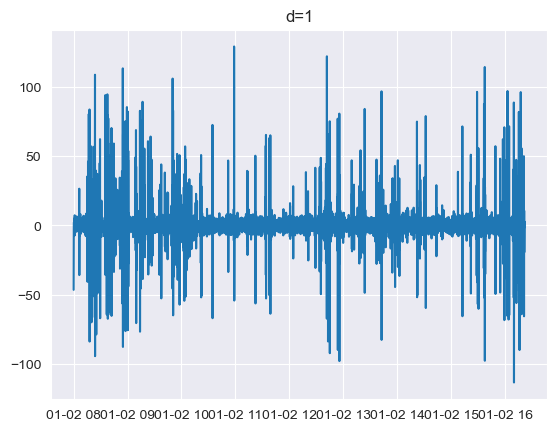

In [10]:
plt.figure()
plt.plot(train_data_diff)
plt.title('d=1')
plt.show()

/var/folders/90/3xy67qxj76v0lkc50q__s4t80000gn/T/ipykernel_76840/2485130713.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()


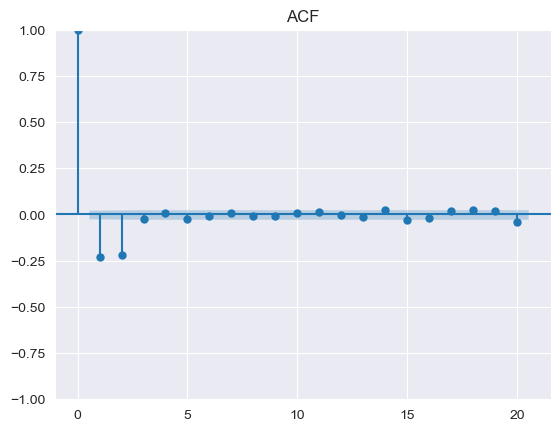

In [11]:
acf = plot_acf(train_data_diff, lags=20)
plt.title("ACF")
acf.show()

/var/folders/90/3xy67qxj76v0lkc50q__s4t80000gn/T/ipykernel_76840/4173882508.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pacf.show()


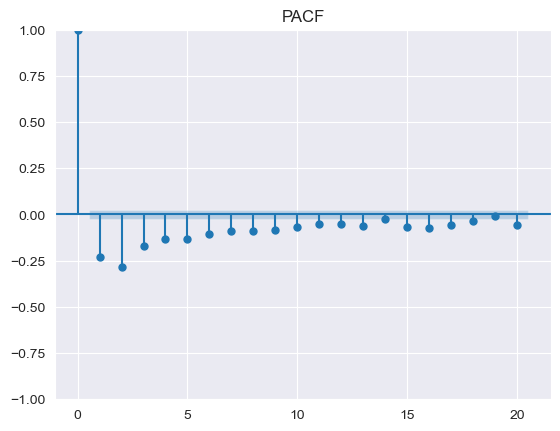

In [12]:
pacf = plot_pacf(train_data_diff, lags=20)
plt.title("PACF")
pacf.show()

In [13]:
model = ARIMA(train_data, order=(4, 0, 1))

/Users/fanxinwei/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5S will be used.
  self._init_dates(dates, freq)
/Users/fanxinwei/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5S will be used.
  self._init_dates(dates, freq)
/Users/fanxinwei/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5S will be used.
  self._init_dates(dates, freq)


In [14]:
results = model.fit()

/Users/fanxinwei/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
forecast = results.forecast(steps=100)

In [16]:
forecast_df = pd.DataFrame(forecast.values, index=test_data.index)

In [17]:
forecast_df

,0
actual_datetime,
2025-01-02 16:21:40,297.486500
2025-01-02 16:21:45,298.937643
2025-01-02 16:21:50,299.598436
2025-01-02 16:21:55,300.119995
2025-01-02 16:22:00,300.457963
...,...
2025-01-02 16:29:35,300.556064
2025-01-02 16:29:40,300.551757
2025-01-02 16:29:45,300.547450


In [18]:
test_data

actual_datetime
2025-01-02 16:21:40    296.936620
2025-01-02 16:21:45    295.314516
2025-01-02 16:21:50    292.646154
2025-01-02 16:21:55    291.393750
2025-01-02 16:22:00    288.523077
                          ...    
2025-01-02 16:29:35    287.923077
2025-01-02 16:29:40    285.888889
2025-01-02 16:29:45    291.176056
2025-01-02 16:29:50    283.926230
2025-01-02 16:29:55    287.149254
Name: avg_price, Length: 100, dtype: float64

In [19]:
differences = forecast_df[0] - test_data
differences

actual_datetime
2025-01-02 16:21:40     0.549881
2025-01-02 16:21:45     3.623127
2025-01-02 16:21:50     6.952283
2025-01-02 16:21:55     8.726245
2025-01-02 16:22:00    11.934886
                         ...    
2025-01-02 16:29:35    12.632987
2025-01-02 16:29:40    14.662868
2025-01-02 16:29:45     9.371394
2025-01-02 16:29:50    16.616916
2025-01-02 16:29:55    13.389588
Length: 100, dtype: float64

In [20]:
total_difference = differences.abs().sum()
total_difference

927.734805678197

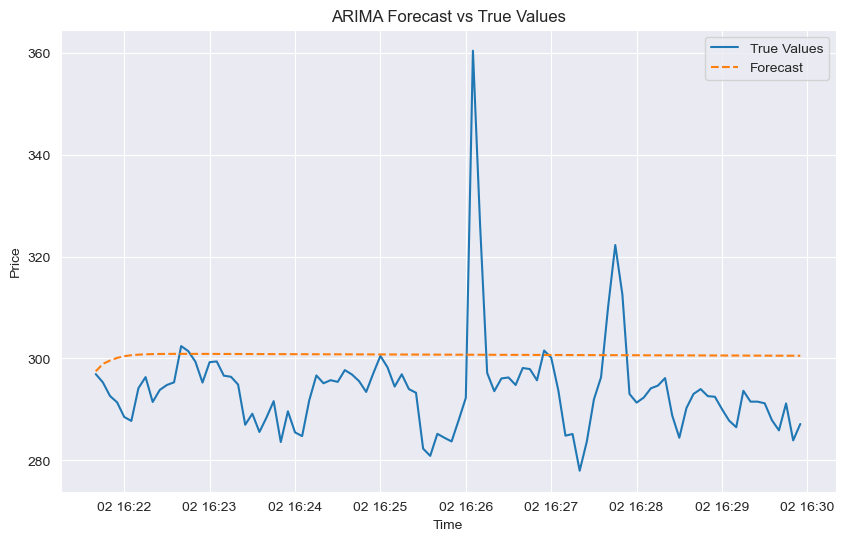

In [21]:
plt.figure(figsize=(10, 6))
# plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='True Values')
plt.plot(forecast_df, label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('ARIMA Forecast vs True Values')
plt.legend()
plt.show()